In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
from livelossplot import PlotLosses
import tensorflow as tf
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils import *

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [2]:
num_samples = 100000
N=500
bs=100000
deep=False
reset(4)

def get_data(mu_1=0.,mu_2=2.,mu_3=0.,scale_p=0.1,scale_q=0.1,scale_m=1.,mtype="mix"):
    
    p = tfd.Normal(loc=mu_1, scale=scale_p)
    q = tfd.Normal(loc=mu_2, scale=scale_q) 
   
    m = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)
    
        
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
    m_samples_ = m.sample([num_samples])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

mu_1=-2.
mu_2=2.
mu_3=0.

scale_p=0.1
scale_q=0.2
scale_m=2.

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)



(100000,)


In [3]:
p_samples = tf.placeholder(tf.float32, shape=[None])
q_samples = tf.placeholder(tf.float32, shape=[None])
m_samples = tf.placeholder(tf.float32, shape=[None])

weights = [tf.get_variable('q1',1.),tf.get_variable('q2',1.),tf.get_variable('q4',1.),tf.get_variable('q5',1.),tf.get_variable('q6',1.),tf.get_variable('s1',1.),tf.get_variable('s2',1.),
           tf.get_variable('t1',1.),tf.get_variable('t2',1.),tf.get_variable('t3',1.),tf.get_variable('b1',1.),tf.get_variable('b2',1.),tf.get_variable('b3',1.)]
prior = tfd.MultivariateNormalDiag(
        loc=len(weights)*[0.],
        scale_diag=len(weights)*[1.])

dloss_func = get_loss(p_samples, q_samples, m_samples, prior)
dloss = dloss_func(*weights)
t_vars = tf.trainable_variables()

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

ps = p_list[np.random.choice(range(len(p_list)),bs)]
qs = q_list[np.random.choice(range(len(q_list)),bs)]
ms = m_list[np.random.choice(range(len(m_list)),bs)]
feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
l = sess.run([dloss,t_vars],feed_dict=feed_dict)
print(l)



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[-2.1355526, [array([-0.74844486], dtype=float32), array([0.04896176], dtype=float32), array([-1.5364704], dtype=float32), array([-0.7165909], dtype=float32), array([-0.1574322], dtype=float32), array([-0.41553283], dtype=float32), array([-0.14673996], dtype=float32), array([0.02216816], dtype=float32), array([0.8122548], dtype=float32), array([0.45707667], dtype=float32), array([1.7037987], dtype=float32), array([1.5918928], dtype=float32), array([1.3993071], dtype=float32)]]


In [8]:
# Initialize the HMC transition kernel. Change to NUTS
num_results = int(10000) # 10K
num_burnin_steps = int(2000)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=dloss_func,
        num_leapfrog_steps=3,
        step_size=1.), #just small enough to have an acc_rate >.6
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# NUTS = tfp.mcmc.NoUTurnSampler(
#         target_log_prob_fn=dloss_func,
#         step_size=1.)

NUTS = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=dloss_func, step_size=1., max_tree_depth=5, max_energy_diff=1000.0, unrolled_leapfrog_steps=1
)

# adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
#     NUTS, 1,
#     step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
#     step_size_getter_fn=lambda pkr: pkr.step_size,
#     log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio
# )

adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    NUTS, 1000,
    target_accept_prob=0.5,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, target_lp = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=weights,
      kernel=adaptive_kernel,
      trace_fn=lambda _, pkr: pkr.inner_results.target_log_prob)
# trace_fn=lambda _, pkr: pkr.inner_results.target_log_prob)
    
    
  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
#   is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return samples, sample_mean, sample_stddev, target_lp

sample_weights, sample_mean, sample_stddev, target_lp = run_chain()

ps = p_list[np.random.choice(range(len(p_list)),bs)]
qs = q_list[np.random.choice(range(len(q_list)),bs)]
ms = m_list[np.random.choice(range(len(m_list)),bs)]
feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
[sw,sm,sstd,tlp] = sess.run([sample_weights, sample_mean, sample_stddev, target_lp],feed_dict=feed_dict)


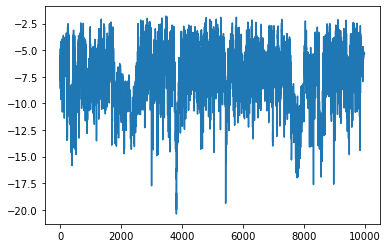

In [9]:
plt.plot(tlp)

In [10]:
def log_ratio_predictive(x,weights):
    posterior_prediction=[]
    for i,weight in enumerate(weights):
        if i%5==0:
            [q1,q2,q4,q5,q6,s1,s2,t1,t2,t3,b1,b2,b3]=weight
            h1 = (x-q1)*(x-q1)*s1 + (x-q4)*t1 + b1 
            h2 = (x-q2)*(x-q2)*s2 + (x-q5)*t2 + b2
            h3 = t3*(x-q6) + b3
            pred = h1 - h2
            posterior_prediction.append(pred)
    posterior_prediction=np.array([xi for xi in posterior_prediction])
    return posterior_prediction.T.tolist(), posterior_prediction.T, posterior_prediction.mean(0), posterior_prediction.std(0) # 100 weights x 1000 samplesposterior_prediction

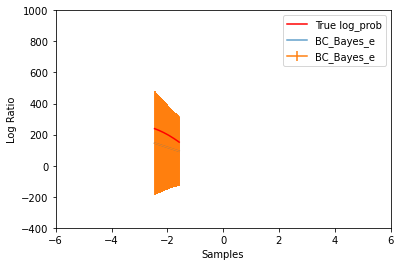

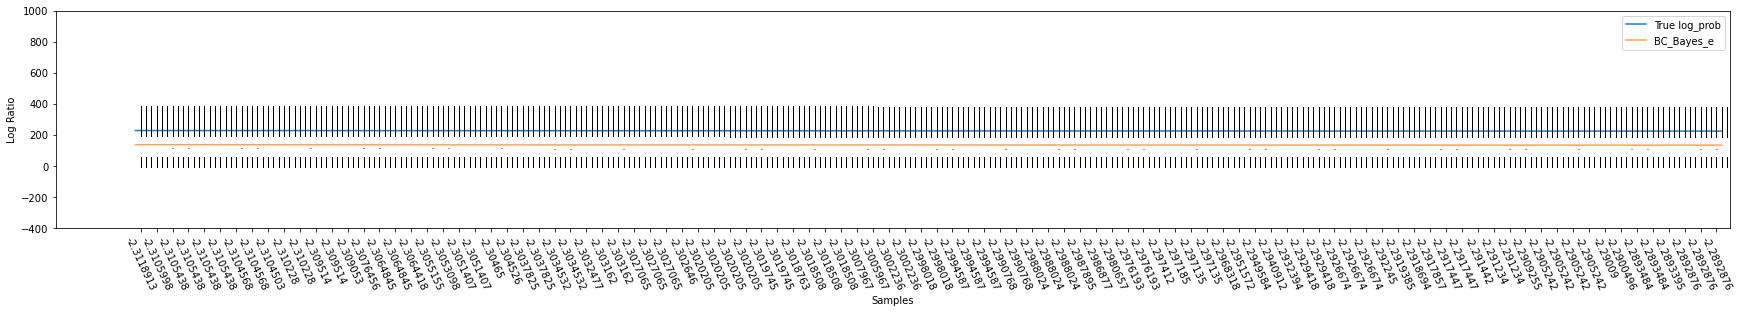

Text(0, 0.5, 'KLD')

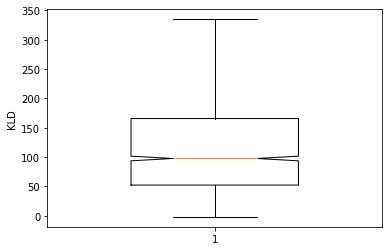

In [11]:
x_s = ps
sw_=sw[-500:]
post,kl_post, post_pred,post_std = log_ratio_predictive(x_s, np.squeeze(np.asarray(sw_).T))

x_sorted = []
m_sorted = []
s_sorted = []
p_sorted = []
[(x_sorted.append(a),m_sorted.append(b), s_sorted.append(c), p_sorted.append(d)) for a,b,c,d in sorted(zip(x_s,post_pred, post_std, post))]

fig1, ax = plt.subplots()
plt.plot(x_sorted, norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',c='r')
plt.plot(x_sorted, m_sorted,label='BC_Bayes_e',alpha=0.7)
quan = [np.abs(np.quantile(p_, .05)-np.quantile(p_, .95)) for p_ in p_sorted]
plt.errorbar(x_sorted, m_sorted, yerr = quan,label='BC_Bayes_e')

#     plt.scatter(x_sorted,norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',alpha=0.99,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-6,6)
plt.ylim(-400,1000)
plt.show()

fig1, ax = plt.subplots(figsize=(30,4))
plt.plot(norm.logpdf(x_sorted[100:400],mu_1,scale_p)-norm.logpdf(x_sorted[100:400],mu_2,scale_q),label='True log_prob',alpha=0.99)
plt.plot(m_sorted[100:400],label='BC_Bayes_e',alpha=0.7)
plt.boxplot(p_sorted[100:400],widths=0.05,notch=True,labels=x_sorted[100:400], showfliers=False, showbox=False, showcaps=False)
plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xticks(rotation = -65)
plt.locator_params(axis='x', nbins=100)
plt.ylim(-400,1000)

plt.show()

fig1, ax = plt.subplots()
plt.boxplot(kl_post.mean(0),widths=0.5,notch=True, showfliers=False)
plt.ylabel("KLD")

In [8]:
true_KL = np.log(scale_q/scale_p) + ((scale_p**2 + (mu_1-mu_2)**2)/(2*scale_q**2)) - 0.5
print(true_KL)

200.31814718055992


In [ ]:
# pip install -U tensorflow-probability==0.6.0